### Monai Model ile "Daire, Kare, Üçgen, Elips" nesneleri Segmente Etme

In [ ]:
# Kütüphaneleri yükle
!pip install monai matplotlib numpy torch torchvision opencv-python

Gerekli Kütüphaneler

In [ ]:
import numpy as np
import cv2
import torch
from torch import nn
import random
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.optimizers import Novograd
from monai.transforms import ToTensor
from torchvision.transforms import ToTensor

Görüntü Üretme Fonksiyonu

In [35]:
def generate_synthetic_image(image_size=(256, 256), nesne_sayisi=10, label_nesnesi="daire"):
    """
    Kullanıcının belirlediği şekil için etiket (label) oluşturan fonksiyon.
    Bu fonksiyon, belirtilen sayıda şekli (daire, kare, dikdörtgen, üçgen, elips) bir görüntüye rastgele yerleştirir
    ve aynı zamanda belirli bir nesne türüne ait etiket oluşturur.

    Args:
    - image_size (tuple): Oluşturulacak görüntünün boyutu (varsayılan 256x256)
    - nesne_sayisi (int): Görüntüye eklenen nesne sayısı (varsayılan 10)
    - label_nesnesi (str): Etiket oluşturulacak şekil türü (örneğin, "daire", "kare" vb.)

    Returns:
    - img (numpy.ndarray): Oluşturulmuş sentetik görüntü
    - label (numpy.ndarray): Nesne türü için etiket görüntüsü
    """
    # Siyah bir görüntü oluşturuluyor (0'lar)
    img = np.zeros(image_size, dtype=np.uint8)
    # Etiket görüntüsü (nesne türünün yerini belirlemek için siyah arkaplan)
    label = np.zeros(image_size, dtype=np.uint8)

    # Şekil türleri listesi
    shapes = ["daire", "kare", "dikdortgen", "ucgen", "elips"]

    # Nesneleri rastgele yerleştiriyoruz
    for i in range(nesne_sayisi):
        shape = shapes[i % len(shapes)]  # Nesneleri sırayla ekle

        # Nesnenin konumunu rastgele belirliyoruz
        x, y = random.randint(20, image_size[0] - 20), random.randint(20, image_size[1] - 20)
        size = random.randint(15, 40)  # Nesne boyutunu rastgele belirliyoruz
        color = random.randint(50, 255)  # Nesnenin rengini rastgele belirliyoruz

        # Eğer şekil daire ise
        if shape == "daire":
            # Görüntüye daire ekliyoruz
            cv2.circle(img, (x, y), size, color, -1)
            # Eğer bu şekil, kullanıcı tarafından belirtilen etiket nesnesi ile eşleşiyorsa, etiket görüntüsüne de daire ekliyoruz
            if shape == label_nesnesi:
                cv2.circle(label, (x, y), size, 255, -1)

        # Eğer şekil kare ise
        elif shape == "kare":
            # Görüntüye kare ekliyoruz
            cv2.rectangle(img, (x, y), (x + size, y + size), color, -1)
            # Eğer bu şekil, kullanıcı tarafından belirtilen etiket nesnesi ile eşleşiyorsa, etiket görüntüsüne de kare ekliyoruz
            if shape == label_nesnesi:
                cv2.rectangle(label, (x, y), (x + size, y + size), 255, -1)

        # Eğer şekil dikdörtgen ise
        elif shape == "dikdortgen":
            # Görüntüye dikdörtgen ekliyoruz (yükseklik boyutunu boyutun 1.5 katı olarak ayarlıyoruz)
            cv2.rectangle(img, (x, y), (x + size, y + int(size * 1.5)), color, -1)
            # Eğer bu şekil, kullanıcı tarafından belirtilen etiket nesnesi ile eşleşiyorsa, etiket görüntüsüne de dikdörtgen ekliyoruz
            if shape == label_nesnesi:
                cv2.rectangle(label, (x, y), (x + size, y + int(size * 1.5)), 255, -1)

        # Eğer şekil üçgen ise
        elif shape == "ucgen":
            # Üçgenin köşe noktalarını belirliyoruz
            pts = np.array([[x, y - size], [x - size, y + size], [x + size, y + size]], np.int32)
            # Görüntüye üçgen ekliyoruz
            cv2.fillPoly(img, [pts], color)
            # Eğer bu şekil, kullanıcı tarafından belirtilen etiket nesnesi ile eşleşiyorsa, etiket görüntüsüne de üçgen ekliyoruz
            if shape == label_nesnesi:
                cv2.fillPoly(label, [pts], 255)

        # Eğer şekil elips ise
        elif shape == "elips":
            # Görüntüye elips ekliyoruz
            cv2.ellipse(img, (x, y), (size, size // 2), 0, 0, 360, color, -1)
            # Eğer bu şekil, kullanıcı tarafından belirtilen etiket nesnesi ile eşleşiyorsa, etiket görüntüsüne de elips ekliyoruz
            if shape == label_nesnesi:
                cv2.ellipse(label, (x, y), (size, size // 2), 0, 0, 360, 255, -1)

    # Sonuç olarak, oluşturulmuş görüntüyü ve etiket görüntüsünü döndürüyoruz
    return img, label


Örnek Görüntü Üretimi

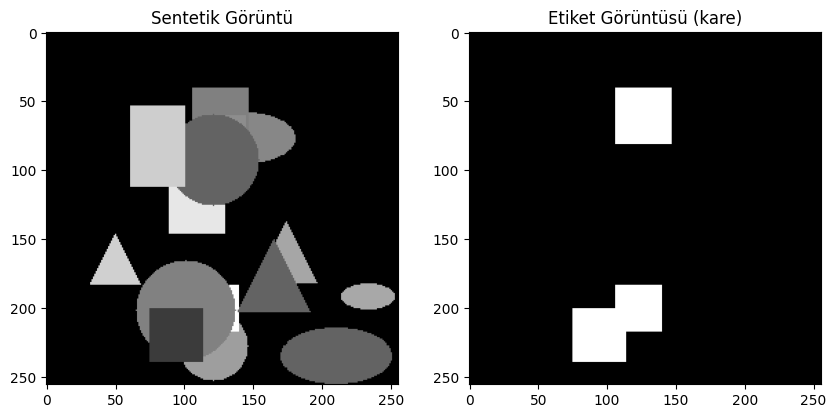

In [38]:
# Kullanıcıdan nesne türünü alıyoruz (daire, kare, dikdörtgen, üçgen, elips vb.)
nesne_turu = input("Nesne Türünü Giriniz : daire, kare, dikdortgen, ucgen, elips")

if nesne_turu in ["daire", "kare", "dikdortgen", "ucgen", "elips"]:
    # Etiket olarak hangi nesnenin kullanılacağını belirliyoruz
    label_nesnesi = nesne_turu  # Kullanıcının seçtiği nesne türü etiket olarak kullanılacak

    # Sentetik görüntü ve etiket görüntüsü oluşturuyoruz
    # 15 nesne eklenecek ve etiket olarak belirlenen şekil türü kullanılacak
    img, label = generate_synthetic_image(nesne_sayisi=15, label_nesnesi=label_nesnesi)

    # 1 satır ve 2 sütunlu bir alt grafik oluşturuyoruz
    # Bu grafik, bir görüntü ve etiketin yan yana gösterilmesini sağlar
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # İlk alt grafikte (solda), oluşturulan sentetik görüntüyü gösteriyoruz
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Sentetik Görüntü")  # Başlık olarak 'Sentetik Görüntü' yazıyoruz

    # İkinci alt grafikte (sağda), etiket görüntüsünü gösteriyoruz
    ax[1].imshow(label, cmap="gray")
    ax[1].set_title(f"Etiket Görüntüsü ({label_nesnesi})")  # Başlıkta etiket nesnesinin türünü belirtiyoruz

    # Görselleri ekranda gösteriyoruz
    plt.show()
else:
    print(f"Geçersiz nesne türü: {nesne_turu}. Lütfen geçerli bir nesne türü giriniz.")

Eğitim İçin Monai Dataset oluşturma

In [ ]:
# SyntheticDataset sınıfını tanımlıyoruz
# Bu sınıf, sentetik görüntüler oluşturup bu görüntüleri model için veriye dönüştürmeyi amaçlar
class SyntheticDataset(Dataset):
    def __init__(self, num_samples=100, label_nesnesi="daire"):
        """
        Sentetik görüntüleri oluşturmak için kullanılan sınıfın başlatıcısı.
        
        :param num_samples: Eğitimde kullanılacak örnek sayısı
        :param label_nesnesi: Etiket olarak kullanılacak nesne türü (örneğin: daire, kare vb.)
        """
        self.num_samples = num_samples  # Eğitim için üretilecek toplam örnek sayısı
        self.label_nesnesi = label_nesnesi  # Etiket olarak kullanılacak nesne türü

    def __len__(self):
        # Dataset'in uzunluğunu döndürüyoruz (kaç tane örnek olduğunu belirtir)
        return self.num_samples

    def __getitem__(self, idx):
        """
        Belirli bir örnek için sentetik görüntü ve etiket üretir.
        
        :param idx: Görüntü indexi, veri yükleyici her defasında çağırır
        :return: img ve label: Oluşturulan sentetik görüntü ve etiket
        """
        # generate_synthetic_image fonksiyonu ile bir sentetik görüntü ve etiket oluşturuyoruz
        img, label = generate_synthetic_image(nesne_sayisi=15, label_nesnesi=self.label_nesnesi)
        
        # Görüntüyü Tensor formatına dönüştürüp, normalize ediyoruz (0-1 arası değer)
        img = ToTensor()(img).unsqueeze(0) / 255.0  # Normalize et (BCHW formatında)
        
        # Etiketi Tensor formatına dönüştürüp, normalize ediyoruz (0-1 arası değer)
        label = ToTensor()(label).unsqueeze(0) / 255.0  # Normalize et (BCHW formatında)
        
        # Görüntü ve etiketleri döndürüyoruz
        return img, label

# Eğitim setini oluşturuyoruz
# 500 örnek üretilmesini istiyoruz ve etiket olarak 'daire' nesnesi kullanılacak
train_dataset = SyntheticDataset(num_samples=500, label_nesnesi="daire")

# DataLoader ile veri kümesini mini-batch'lere bölelim
# Bu, veri kümesinin eğitim sırasında daha verimli kullanılmasını sağlar
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # batch_size=8: 8 örneği bir seferde yükle, shuffle=True: verileri karıştır


Ekran Kartı Kullanımını Test Etme

In [ ]:
# Ekran kartı kullanılıyor mu 
import torch
print(torch.cuda.is_available())

import torch
print(torch.__version__)

import torch
print(torch.cuda.is_available())  # True döndürmeli
print(torch.cuda.current_device())  # Kullanılabilir GPU'nun id'si
print(torch.cuda.get_device_name(0))  # GPU'nun adı


UNet Modeli Tanımlama ve Eğitim

In [ ]:
# Cihazı belirliyoruz (CUDA varsa GPU kullanılır, yoksa CPU kullanılır)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet modelini oluşturuyoruz
model = UNet(
    spatial_dims=2,  # 2D görüntüler için model
    in_channels=1,   # Giriş kanal sayısı (tek renkli görüntüler için 1)
    out_channels=1,  # Çıkış kanal sayısı (tek kanal için 1)
    channels=(16, 32, 64, 128, 256),  # Her katmandaki kanal sayıları
    strides=(2, 2, 2, 2),  # Her katmandaki stride değerleri
    num_res_units=2  # Residual unit sayısı (daha derin model)
).to(device)  # Modeli belirtilen cihaza (CPU veya GPU) taşıyoruz

# Dice Loss fonksiyonunu oluşturuyoruz. Sigmoid uygulanacak, çünkü ikili segmentasyon yapıyoruz
loss_function = DiceLoss(sigmoid=True)

# Modeli optimize etmek için Novograd optimizatörünü kullanıyoruz. Öğrenme oranını 0.001 olarak belirliyoruz.
optimizer = Novograd(model.parameters(), lr=0.001)

# Eğitim için epoch sayısını belirliyoruz
num_epochs = 20

# Eğitim döngüsüne başlıyoruz
for epoch in range(num_epochs):
    epoch_loss = 0  # Bu epoch'daki toplam kaybı tutacak değişken
    
    # Her batch için eğitim adımlarını tekrarlıyoruz
    for batch in train_loader:
        img, label = batch  # img (görüntü), label (etiket) verilerini alıyoruz
        img, label = img.to(device), label.to(device)  # Görüntü ve etiketleri cihaza taşıyoruz

        optimizer.zero_grad()  # Önceki gradientleri sıfırlıyoruz (çünkü her batch'te yeni gradient hesaplanacak)
        
        # Modeli kullanarak tahmin yapıyoruz
        output = model(img)
        
        # Kaybı hesaplıyoruz
        loss = loss_function(output, label)
        
        # Geriye doğru yayılım (backpropagation) işlemi
        loss.backward()
        
        # Modelin parametrelerini güncelliyoruz
        optimizer.step()
        
        # Epoch kaybını güncelliyoruz
        epoch_loss += loss.item()

    # Epoch sonrasında kaybı yazdırıyoruz
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Modeli kaydediyoruz
modeladi = input("Eğitilen model adını giriniz : ")
torch.save(model.state_dict(), f"{modeladi}.pth")  # Modelin öğrenilen ağırlıklarını 'def_model.pth' dosyasına kaydediyoruz

C:\Users\Ersin\AppData\Local\Temp\ipykernel_17260\1257819658.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


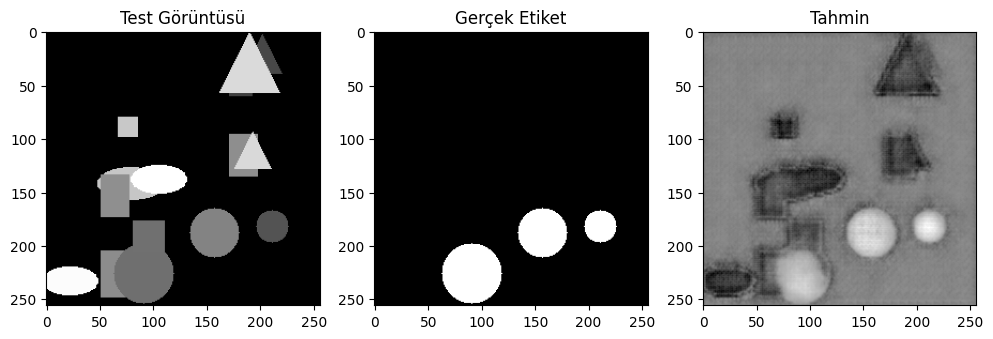

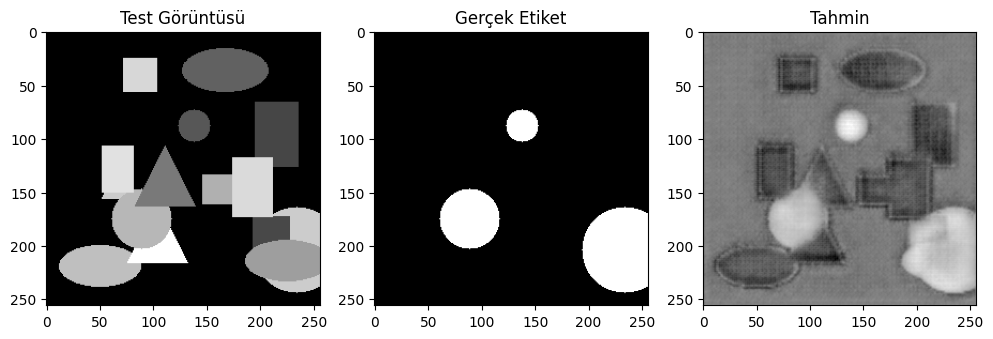

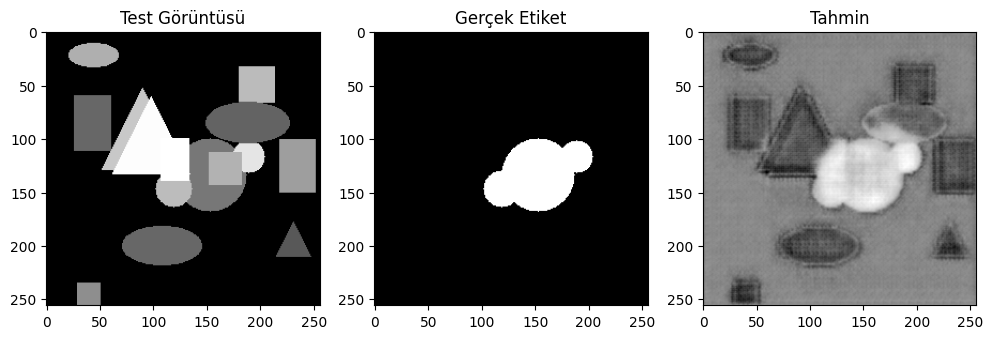

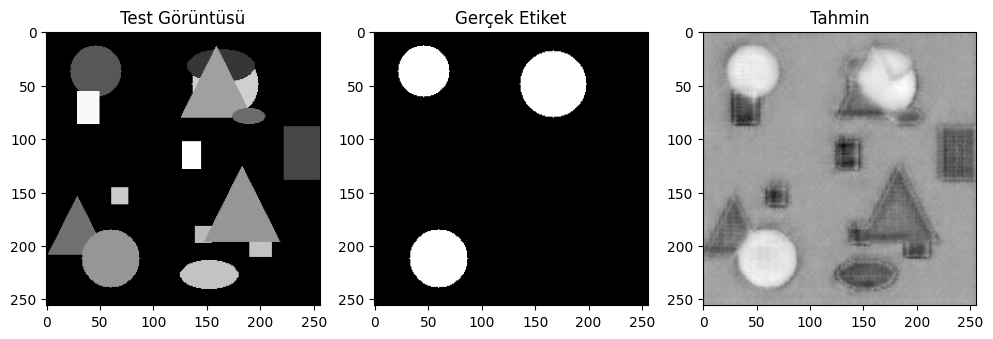

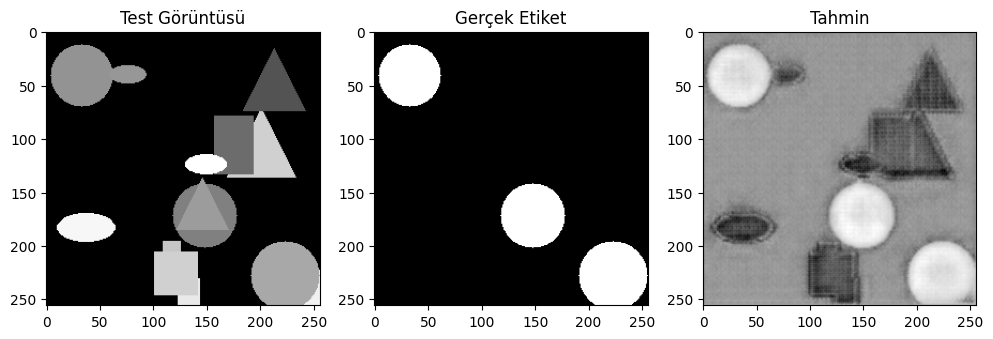

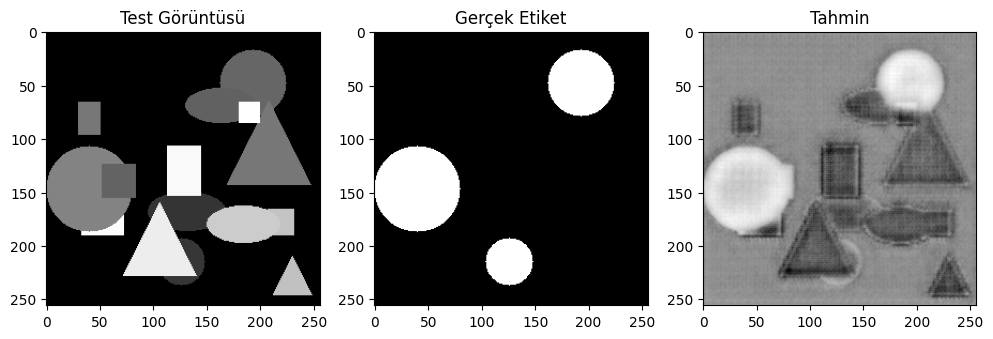

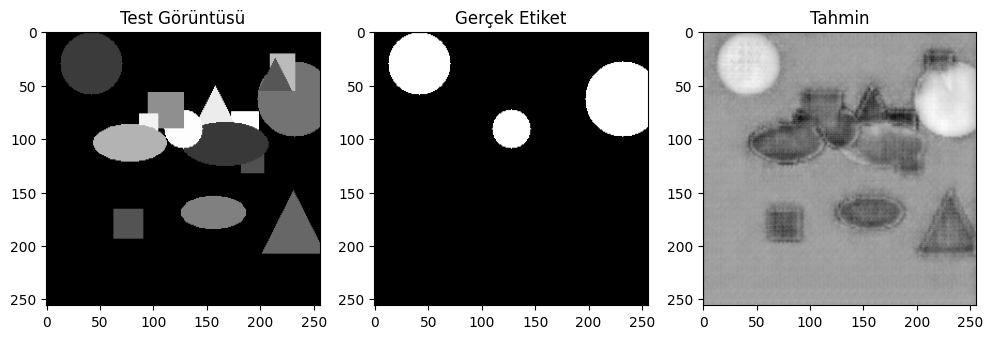

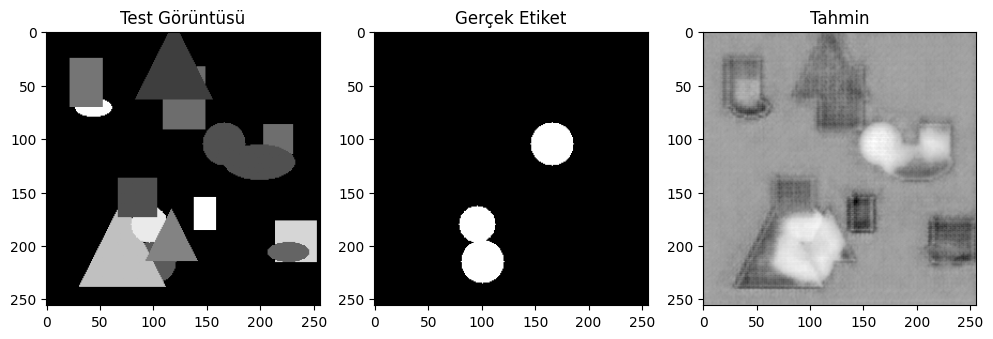

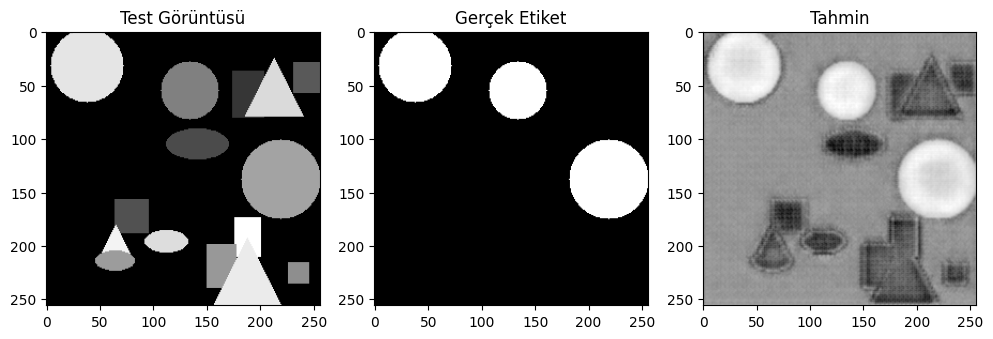

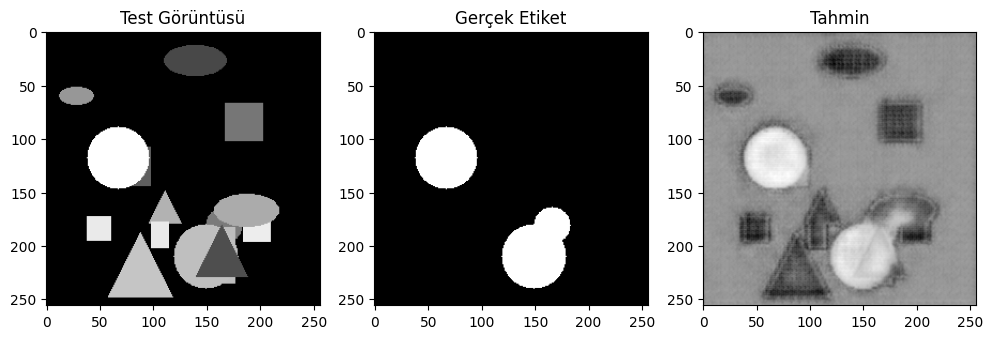

In [ ]:
# Kullanıcıdan nesne türünü alıyoruz
nesne_turu = input("Nesne Türünü Giriniz : daire, kare, dikdortgen, ucgen, elips")

# Geçerli nesne türünü kontrol et
if nesne_turu in ["daire", "kare", "dikdortgen", "ucgen", "elips"]:
    # Kullanıcı ana dizini (Home directory)
    user_home = os.path.expanduser("~")

    # Benim projem Masaüstünde Github\2D_Segmentation içinde yer almakta buna göre kendi projenizde düzenleyiniz
    # Kullanıcının Desktop dizinini bulmak için
    desktop_dir = os.path.join(user_home, "Desktop")

    # Model dosyasının bulunduğu dizini dinamik olarak oluştur
    model_dir = os.path.join(desktop_dir, "GitHub", "2D_Segmentation")
    model_path = os.path.join(model_dir, f"{nesne_turu}.pth")

    # Model yolunu kontrol et
    if not os.path.exists(model_path):
        print(f"Model dosyası bulunamadı: {model_path}")
    
    # Modeli seçmek ve yüklemek
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    ).to(device)

    # Modeli yükle
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # 'tmp' klasörünü oluşturuyoruz, eğer yoksa
    output_dir = "tmp"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Görüntü üretip tahmin yapma ve kaydetme
    for i in range(10):
        img, label = generate_synthetic_image(nesne_sayisi=15, label_nesnesi=nesne_turu)
        img_tensor = ToTensor()(img).unsqueeze(0) / 255.0  # Normalize et
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            output = model(img_tensor)
        
        pred = output.cpu().numpy().squeeze()

        # Kaydetme işlemi
        img_path = os.path.join(output_dir, f"img{i}.png")
        label_path = os.path.join(output_dir, f"label{i}.png")
        pred_path = os.path.join(output_dir, f"pred{i}.png")

        # Görüntü, etiket ve tahmini kaydet
        plt.imsave(img_path, img, cmap="gray")
        plt.imsave(label_path, label, cmap="gray")
        plt.imsave(pred_path, pred, cmap="gray")

        # Sonuçları görselleştirme (isteğe bağlı)
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Test Görüntüsü")
        ax[1].imshow(label, cmap="gray")
        ax[1].set_title("Gerçek Etiket")
        ax[2].imshow(pred, cmap="gray")
        ax[2].set_title("Tahmin")
        plt.show()
else:
    print(f"Geçersiz nesne türü: {nesne_turu}. Lütfen geçerli bir nesne türü giriniz.")